# Video Explanation

I creted this

[https://www.youtube.com/watch?v=MeY7KCvozOw](https://www.youtube.com/watch?v=MeY7KCvozOw)

In [1]:
# check karo dataset kaha save h
!du -hs /kaggle/input/amazon-reviews/*

657M	/kaggle/input/amazon-reviews/amazon_review_polarity_csv.tgz
168M	/kaggle/input/amazon-reviews/test.csv
1.5G	/kaggle/input/amazon-reviews/train.csv


In [23]:
import pandas as pd

"""
bhai file import karenge,
and thode thode rows (300k) import kar ke, pre-process kar ke, train karenge
pandas mai
"""
columns = ["sentiment", "title", "text"]

train_iter = pd.read_csv("/kaggle/input/amazon-reviews/train.csv", chunksize=3_00_000, header=None, names=columns)
test_iter = pd.read_csv("/kaggle/input/amazon-reviews/test.csv", chunksize=10_000, header=None, names=columns)

In [24]:
"""
yrr vo toh iterater h na, usse read nhi kar sakte,
vo toh bas starting address ko point kar raha h
toh uss pointer se next 300k tak read karenge
"""
df_train = next(train_iter)
df_test = next(test_iter)

# 300k rows import ke h, ispe pahale kaam karenge, fir aage baat karnge
len(df_train), len(df_test)

(300000, 10000)

In [25]:
"""
there are around 3.6 million rows in training dataset,
toh agar kutch thousand rows faltu bhe nikal gai, like duplicate, null, toh sidhe remove kar do
zada fark nhi padega
"""

df_train = df_train.dropna()
df_train = df_train.drop_duplicates()

df_test = df_test.dropna()
df_test = df_test.drop_duplicates()

df_train['sentiment'] = df_train['sentiment'] - 1
df_test['sentiment'] = df_test['sentiment'] - 1

len(df_train), len(df_test)

(299974, 9998)

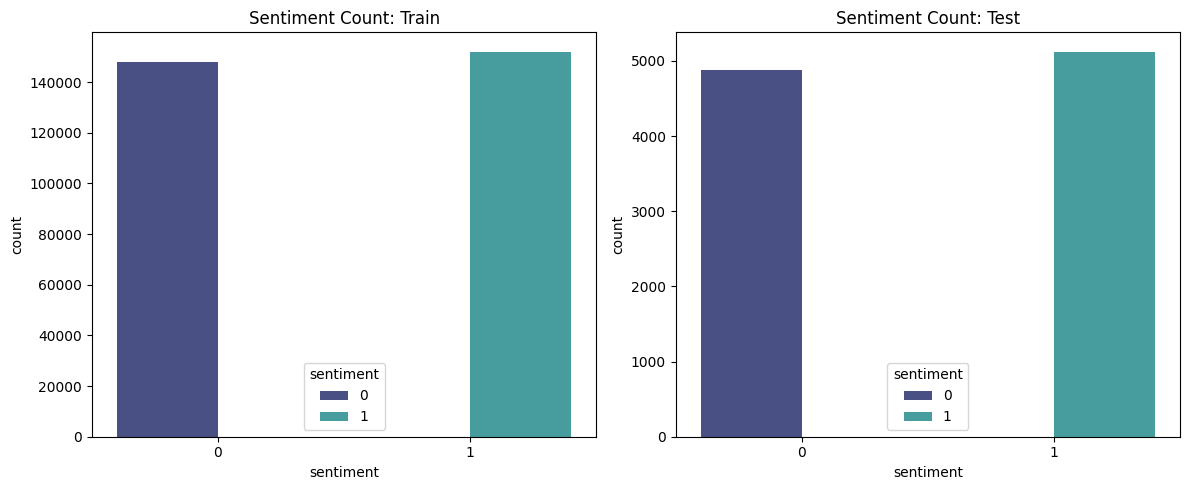

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First plot on the left
sns.countplot(x='sentiment', data=df_train, hue='sentiment', palette="mako", ax=axes[0])
axes[0].set_title("Sentiment Count: Train")

# Second plot on the right
sns.countplot(x='sentiment', data=df_test,  hue='sentiment',palette="mako", ax=axes[1])
axes[1].set_title("Sentiment Count: Test")

plt.tight_layout()
plt.show()

In [27]:
"""
kutch features dhude ne ka try karenge,
like title word count, description word count
their ratio (title/desc) and (desc/title), total words
"""

df_train['title_wc'] = df_train['title'].map(lambda x: len(x.split()))
df_train['text_wc'] = df_train['text'].map(lambda x: len(x.split()))

df_train['title_to_text_ratio'] = df_train.apply(lambda row: row['title_wc'] / row['text_wc'] if row['text_wc'] != 0 else 0, axis=1)
df_train['text_to_title_ratio'] = df_train.apply(lambda row: row['text_wc'] / row['title_wc'] if row['title_wc'] != 0 else 0, axis=1)

df_train['total_words'] = df_train.apply(lambda row: row['text_wc'] + row['title_wc'], axis=1)

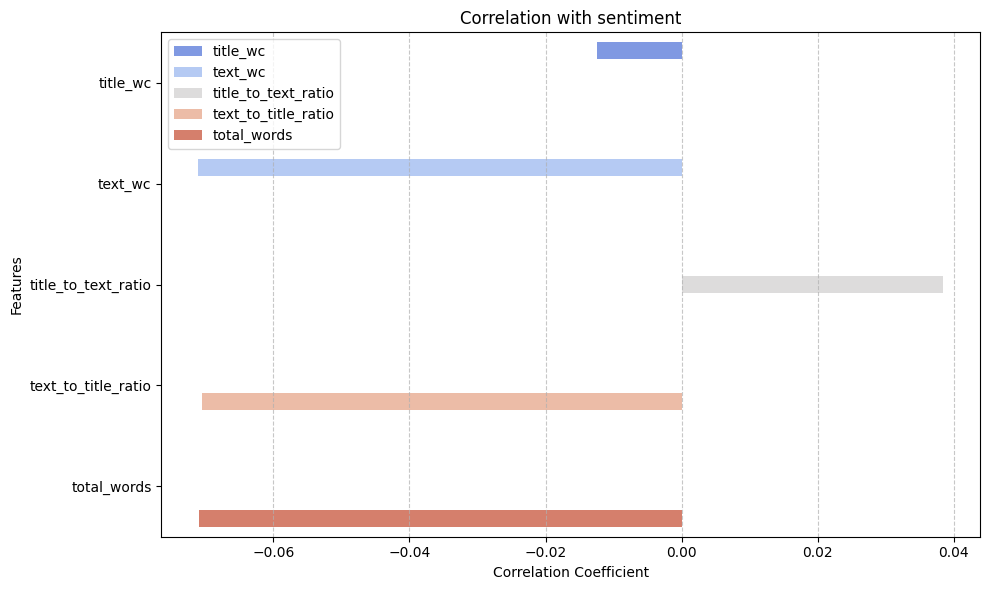

In [28]:
"""
jo features uppar dhude h, unko check karenge ke
if they are of any use or not, buy making their correlation with sentiment
"""

correlation = df_train.drop(columns=["text", "title"]).corrwith(df_train["sentiment"]).drop("sentiment")

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.values, y=correlation.index, hue=correlation.index, palette="coolwarm")

plt.title("Correlation with sentiment")
plt.ylabel("Features")
plt.xlabel("Correlation Coefficient")

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.0 MB/s eta 0:00:00


In [29]:
import re
import string
import contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

"""
ab apan data clean karenge, like letters lower karenge,
agar koi faltu cheeze h like mail, links, emojis, punctuations, stop word vo remove karo
and agar chart word h, spelling mistakes h toh theek karo

fir additionally stemming ya lemmatization bhe dheak sakte h
"""

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # Emoticons
    u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # Transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # Flags
    u"\U00002700-\U000027BF"  # Dingbats
    u"\U000024C2-\U0001F251"  # Enclosed characters
    "]+", flags=re.UNICODE
)

def clean_text(df, column):
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace(r"http\S+","")
    df[column] = df[column].str.replace(r"@"," at ")
    df[column] = df[column].apply(lambda x: contractions.fix(x)) # short form words to long form mai convert karta h
    df[column] = df[column].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))
    df[column] = df[column].apply(lambda x: emoji_pattern.sub(r'', x))
    # df[column] = df[column].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))
    
    # df[column] = df[column].apply(lambda x: TextBlob(x).correct().string)
    df[column] = df[column].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

    return df[column]

df_train['title_cleaned'] = clean_text(df_train, 'title')
df_train['text_cleaned'] = clean_text(df_train, 'text')

df_test['title_cleaned'] = clean_text(df_test, 'title')
df_test['text_cleaned'] = clean_text(df_test, 'text')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer

x_train, y_train = df_train[['text', 'title']], df_train['sentiment']
x_test, y_test = df_test[['text', 'title']], df_test['sentiment']

tokenizer = Tokenizer(oov_token='nothing')
all_texts = list(x_train['text']) + list(x_train['title'])
tokenizer.fit_on_texts(all_texts)

vocab_length = len(tokenizer.word_index)
vocab_length

376400

In [31]:
x_train_seq_title = tokenizer.texts_to_sequences(x_train['title'])
x_train_seq_text = tokenizer.texts_to_sequences(x_train['text'])

x_test_seq_title = tokenizer.texts_to_sequences(x_test['title'])
x_test_seq_text = tokenizer.texts_to_sequences(x_test['text'])

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_padded_tokens_title = pad_sequences(x_train_seq_title)[:len(y_train)]
train_padded_tokens_text = pad_sequences(x_train_seq_text)[:len(y_train)]

test_padded_tokens_title = pad_sequences(x_test_seq_title, maxlen=len(train_padded_tokens_title[0]))[:len(y_test)]
test_padded_tokens_text = pad_sequences(x_test_seq_text, maxlen=len(train_padded_tokens_text[0]))[:len(y_test)]

word_count_title, word_count_text = (len(train_padded_tokens_title[0]), len(train_padded_tokens_text[0]))
word_count_title, word_count_text

(29, 240)

In [33]:
train_padded_tokens_text.shape, train_padded_tokens_title.shape

((299974, 240), (299974, 29))

In [34]:
test_padded_tokens_text.shape, test_padded_tokens_title.shape

((9998, 240), (9998, 29))

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate

# First input pipeline (text)
input_1 = Input(shape=(train_padded_tokens_text.shape[1],))
x1 = Embedding(len(tokenizer.index_word) + 1, 300)(input_1)
x1 = Bidirectional(LSTM(256))(x1)

# Second input pipeline (title)
input_2 = Input(shape=(train_padded_tokens_title.shape[1],))
x2 = Embedding(len(tokenizer.index_word) + 1, 300)(input_2)
x2 = Bidirectional(LSTM(128))(x2)

# Combine both
merged = Concatenate()([x1, x2])

# Common dense layers
dense = Dense(128, activation="relu")(merged)
dropout = Dropout(0.35)(dense)
output = Dense(1, activation="sigmoid")(dropout)

# Final model
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 240)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 29)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 240, 300)       │    112,920,300 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 29, 300)        │    112,920,300 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 512)            │      1,140,736 │ embedding_2[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 256)            │        439,296 │ embedding_3[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 768)            │              0 │ bidirectional_2[0][0], │
│ (Concatenate)             │                        │                │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         98,432 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            129 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 227,519,193 (867.92 MB)

 Trainable params: 227,519,193 (867.92 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("amazon_review_300.h5", save_weights_only=False, save_freq='epoch')

history = model.fit(
    [train_padded_tokens_text, train_padded_tokens_title], y_train,
    validation_data=([test_padded_tokens_text, test_padded_tokens_title], y_test),
    epochs=1,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 112920300 elements. This may consume a large amount of memory.
  warnings.warn(


9375/9375 ━━━━━━━━━━━━━━━━━━━━ 1445s 154ms/step - accuracy: 0.8819 - loss: 0.2759 - val_accuracy: 0.9184 - val_loss: 0.2124


In [37]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def metrics(y_true, y_hat):
    # Convert y_hat (probability) to 0(<0.5) to 1(>0.5)
    y_pred = np.where(y_hat > .5, 1, 0)

    accuracy = accuracy_score(y_true, y_pred) # Accuracy Score
    f1 = f1_score(y_true, y_pred) # F1 Score
    cm = confusion_matrix(y_true, y_pred) # Confusion Matrix

    # Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_true, y_hat)
    pr_auc = auc(recall, precision)

    return {
        "accuracy": accuracy, "pr_auc": pr_auc,
        "f1_score": f1, "confusion_matrix": cm
    }

In [38]:
y_hat = model.predict([test_padded_tokens_text, test_padded_tokens_title])

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


In [40]:
metrics_score = metrics(y_test, y_hat)
metrics_score

{'accuracy': 0.918383676735347,
 'pr_auc': 0.9747433418369095,
 'f1_score': 0.9193357058125741,
 'confusion_matrix': array([[4532,  342],
        [ 474, 4650]])}

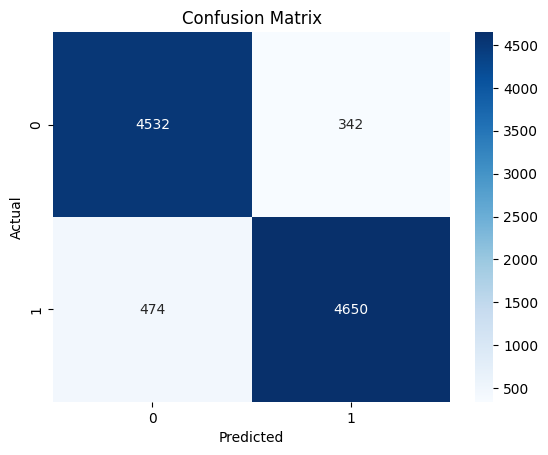

In [44]:
cm = metrics_score["confusion_matrix"]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

# Trained with 400k rows

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=True)
checkpoint = ModelCheckpoint("model_checkpoint.h5", save_weights_only=False, save_freq='epoch')

model.fit(
    [train_padded_tokens_text, train_padded_tokens_title], y_train,
    validation_data=([test_padded_tokens_text, test_padded_tokens_title], y_test),
    epochs=2,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 138874800 elements. This may consume a large amount of memory.
  warnings.warn(
I0000 00:00:1749326394.724339     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 2240s 178ms/step - accuracy: 0.8871 - loss: 0.2679 - val_accuracy: 0.9228 - val_loss: 0.1956
Epoch 2/2
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 2235s 179ms/step - accuracy: 0.9618 - loss: 0.1087 - val_accuracy: 0.9165 - val_loss: 0.2161
